# Import statements

In [1]:
# Necessary imports
import gym
from gym import spaces
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io
import numpy as np
from collections import deque, namedtuple

# For visualization
from IPython.display import HTML
from IPython import display 
import glob

-------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------

# Necessary functions for generating scenario and creating the environment

In [2]:
#Function for normal distribution truncation:

from scipy.stats import truncnorm

def get_truncated_normal(mean, sd, low, upp):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

#Function to get observation (still for single env, need to modify for multi-agent env):

def full_obs(_cap_dem_chosen_req, number_of_actions):
    _obs_min_arr = np.full((288+number_of_actions-1, ), 0)
    for i in range(len(_cap_dem_chosen_req)):
        _obs_min_arr[i+int((number_of_actions-1)/2)] = min(_cap_dem_chosen_req[i])
    return _obs_min_arr

#Function to get the one-hot-encoded vectors for departure and arrival airports:

def one_hot_encode_airport(airport, num_airports):
    encoding = np.zeros(num_airports)
    encoding[airport] = 1
    return encoding

# Example usage
num_airports = 2
airport1 = 0
airport2 = 1

encoded_airport1 = one_hot_encode_airport(airport1, num_airports)
encoded_airport2 = one_hot_encode_airport(airport2, num_airports)

print(encoded_airport1)
print(encoded_airport2)

#Generate full info for the arrival sides:

def generate_info_arv(requests):
    ts_arv = np.empty(shape=(len(requests),), dtype='object')
    for i in range(len(requests)):
        ts_arv[i] = requests[i][1] + requests[i][4]/5
        if ts_arv[i] > 287:
            ts_arv[i] = ts_arv[i] - 287
    return ts_arv

#Generate the multi-agent scenario:

#=======================================================

#Modify the distribution based on historical data later:
def generate_scenario(number_of_requests, num_airports, cap_dict):
    
    #number_of_requests = 1500
    ts_72 = get_truncated_normal(mean=72, sd=36, low=0, upp=287).rvs(int(round(number_of_requests/2)))
    ts_72 = np.round(ts_72)

    ts_216 = get_truncated_normal(mean=216, sd=36, low=0, upp=287).rvs(int(round(number_of_requests/2)))
    ts_216 = np.round(ts_216)

    ts_dep = np.concatenate((ts_72, ts_216))
    ts_dep = ts_dep.astype(int)

    #Generate index for requests:

    index = np.array(list(range(number_of_requests)))

    #Generate origin (0 and 1 are two considered origin airports, 2 represent other airports, encoded in one-hot vector):

    #num_airports = 3
    origin_airport = np.empty(shape=(number_of_requests,), dtype='object')
    destination_airport = np.empty(shape=(number_of_requests,), dtype='object')
    for i in range(number_of_requests):
        _org_airport = one_hot_encode_airport(random.randint(0,1), num_airports)
        _org_airport_list = _org_airport.tolist()
        origin_airport[i] = _org_airport_list
        #Generate destination (the destination will be different with the origin):
        _dest_airport = _org_airport.copy()
        while np.array_equal(_dest_airport, _org_airport):
            np.random.shuffle(_dest_airport)
        _dest_airport_list = _dest_airport.tolist()
        destination_airport[i] = _dest_airport_list

    #Generate flying time (assume between airport 0 and 1 is 2 hour, 0 to 2 and 1 to 2 is arbitrary):

    fly_time = np.empty(shape=(number_of_requests,), dtype='object')
    for i in range (number_of_requests):
        if origin_airport[i] == list([1.0, 0.0]) and destination_airport[i] == list([0.0, 1.0]):
            fly_time[i] = 120
        elif origin_airport[i] == list([0.0, 1.0]) and destination_airport[i] == list([1.0, 0.0]):
            fly_time[i] = random.choice([60, 120, 180])

    #Generate status cap:

    status_cap_dep = np.full((number_of_requests,), 0)
    status_cap_arv = np.full((number_of_requests,), 0)
    

    requests = np.stack((index, ts_dep, origin_airport, destination_airport, fly_time, status_cap_dep), axis=1)

    #Generate full info for the arv side:

    ts_arv = generate_info_arv(requests)

    #pseudo_belong_dep = np.full((number_of_requests,), 0)
    #pseudo_belong_arv = np.full((number_of_requests,), 0)
    
    # Define requests_full as dtype object
    num_entries = len(index)  # Given that 'index' is defined using np.array(list(range(number_of_requests)))
    # Create an empty array of the desired shape with dtype=object
    requests_full = np.empty((num_entries, 8), dtype=object)
    # Fill the array
    data = [index, ts_dep, origin_airport, destination_airport, fly_time, status_cap_dep, ts_arv, status_cap_arv]
    for i, column_data in enumerate(data):
        requests_full[:, i] = column_data

    # airport_req_dict: A dictionary where each key corresponds to a specific airport's requirements. 
    # The key format is 'req_i', where i is the index of the airport. 
    # The value for each key is a numpy array, with each row representing a request and the columns containing different attributes of that request.
    airport_req_dict, _belong_airport_dict = get_airport_req_dict(requests_full, num_airports)

    pot_dem_dict = get_initial_pot_dem_per_airport(airport_req_dict, num_airports)

    cap_dem_dict = get_cap_dem_dict(num_airports, cap_dict, pot_dem_dict)

    return requests_full, airport_req_dict, _belong_airport_dict, pot_dem_dict, cap_dem_dict

def flatten_cap_dem_dict(cap_dem_dict, num_airports):
    cap_dem_dict_flat = {}
    for i in range(num_airports):
        cap_dem_dict_flat['req_{}'.format(i)] = cap_dem_dict['req_{}'.format(i)].flatten()
    return cap_dem_dict_flat

#Get separated req per airport and store in a dict:

def get_airport_req_dict(requests_full, num_airports):
    airport_req_dict = {}
    _belong_airport_dict = {}
    for i in range(num_airports):
        airport_req_dict['req_{}'.format(i)] = np.empty((0, 10)) #This one depends on the number of elements of a final request
        _belong_airport_dict['req_{}'.format(i)] = np.full(num_airports, 0.0, dtype=float)
        _belong_airport_dict['req_{}'.format(i)][i] = float(1.0)
        _belong_airport_dict['req_{}'.format(i)] = _belong_airport_dict['req_{}'.format(i)].tolist()
        
    for i in range(len(requests_full)):
        _found_dep = 0
        _found_arv = 0
        for k in range(num_airports):
            #_found_dep = 0
            #_found_arv = 0
            if requests_full[i][2] == _belong_airport_dict['req_{}'.format(k)]:
                _dep_req = np.append(requests_full[i], 1)
                _dep_req = np.append(_dep_req, 0)
                airport_req_dict['req_{}'.format(k)] = np.vstack((airport_req_dict['req_{}'.format(k)], _dep_req))
                _found_dep = 1

            if requests_full[i][3] == _belong_airport_dict['req_{}'.format(k)]:
                _arv_req = np.append(requests_full[i], 0)
                _arv_req = np.append(_arv_req, 1)
                airport_req_dict['req_{}'.format(k)] = np.vstack((airport_req_dict['req_{}'.format(k)], _arv_req))
                _found_arv = 1

            if _found_dep + _found_arv == 2:
                break
        if _found_dep + _found_arv != 2:
            print("Cannot found both dep and arv at req {}".format(i))
    
    return airport_req_dict, _belong_airport_dict

def generate_deterministic_capacity_dict(num_airports, cap_per_airport_arr): #This function is for 288 slots/ day
    cap_dict = {}
    for i in range(num_airports):
        cap_dict['req_{}'.format(i)] = np.full((288), cap_per_airport_arr[i])
    return cap_dict

def get_date_plot(timeslot_movements, i):
    indices, items = zip(*timeslot_movements)
    sum_of_values = sum(item[1] for item in timeslot_movements)
    print("no of request: ", sum_of_values)
    plt.figure(figsize=(10,6))
    plt.bar(indices, items, width=3.0) 
 
    plt.xlabel('Timeslot') 
    plt.ylabel('No. of movements') 

    plt.title('No. of movements by timeslot in airport' +  str(i)) 

    plt.show()

def get_initial_pot_dem_per_airport(airport_req_dict, num_airports): #Replace req_df to req_df_update to update pot_dem_df #To be replaced with final_sched
    pot_dem_dict = {}
    #TODO: increase speed
    #8 dep 9 arv, 1 dep ts, 6 arv ts
    for i in range(num_airports):
        pot_dem_dict['req_{}'.format(i)] = np.full((288), 0)
        for k in range(len(airport_req_dict['req_{}'.format(i)])):
            _time_slot = int(airport_req_dict['req_{}'.format(i)][k][1]) * int(airport_req_dict['req_{}'.format(i)][k][8]) + int(airport_req_dict['req_{}'.format(i)][k][6]) * int(airport_req_dict['req_{}'.format(i)][k][9])
            pot_dem_dict['req_{}'.format(i)][_time_slot] += 1

    # for i in range(num_airports):
    #     indexed_array = [[index, item] for index, item in enumerate(pot_dem_dict['req_{}'.format(i)])]
    #     get_date_plot(indexed_array, i)
        
    return pot_dem_dict

def get_cap_dem_dict(num_airports, cap_dict, pot_dem_dict):
    cap_dem_dict = {}
    for i in range(num_airports):
        cap_dem_dict['req_{}'.format(i)] = cap_dict['req_{}'.format(i)] - pot_dem_dict['req_{}'.format(i)]
    return cap_dem_dict

[1. 0.]
[0. 1.]


-------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------

# DQN Algorithm Code

In [3]:
# Define Neural Network for Q Network
class QNetwork(nn.Module):
    # Initilize parameters to build model
    def __init__(self, state_size, action_size, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
    
    # Build a network that maps state to action values
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

In [4]:
# Define the hyperparameters
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-2               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# Define the agent
class Agent():
    # Initialize the Agent object
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    # Function to return actions for the given state based on the current policy
    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # change this to just take random action and return the action after mapping
        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    # Function to return actions for test
    def pred(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        # self.qnetwork_local.eval()
        # with torch.no_grad():
        action_values = self.qnetwork_local(state)
        return np.argmax(action_values.cpu().data.numpy())

    # Update the value parameters based on the given batch of experience tuples
    def learn(self, experiences, gamma):

        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        # Compute and minimize the loss
        # Extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        # Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)
        
        # Calculate loss
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update the target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [7]:
# Define the Replay Buffer
class ReplayBuffer:
    # Initialize the Replay Buffer
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    # Add a new experience
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    # Randomly sample a batch of experiences from memory
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

-------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------

# [ACTUAL] Simulator Environment for 2 airports

In [8]:
class TwoAirportSchedEnv(gym.Env):
    def __init__(self, number_of_actions, number_of_requests, num_airports, cap_per_airport_arr):
        super(TwoAirportSchedEnv, self).__init__()
        self.number_of_actions = int(number_of_actions)
        self.number_of_requests = number_of_requests
        self.num_airports = num_airports
        self.cap_per_airport_arr = cap_per_airport_arr
        self.cap_dict = generate_deterministic_capacity_dict(self.num_airports, self.cap_per_airport_arr)
        _exceed_cap = 0         
        while _exceed_cap == 0:
            self.requests_full, self.airport_req_dict, self._belong_airport_dict, self.pot_dem_dict, self.cap_dem_dict = generate_scenario(number_of_requests = self.number_of_requests, num_airports = self.num_airports, cap_dict = self.cap_dict)
            self.cap_dem_dict_flat = flatten_cap_dem_dict(self.cap_dem_dict, self.num_airports)
            for i in range(num_airports):
                _exceed_cap = _exceed_cap + (min(self.cap_dem_dict_flat['req_{}'.format(i)]))

        # initialize the status capacity of all requests in requests_full
        self.initialize_status_capacity(self.cap_dem_dict, self.requests_full)
        # obtain the violate_set
        self.violate_set = self.get_violate_id_set(self.cap_dem_dict, self.requests_full)
        #to choose the request that will be checked
        self.get_req(self.requests_full, self.violate_set)

        #to generate action:
        self.action_space = spaces.Discrete(self.number_of_actions)
        self.observation_space = spaces.Box(low= -np.inf, high= np.inf, shape=(7,), dtype=float)
        self.num_step = 0
        
        self.original_requests = self.requests_full

    def initialize_status_capacity(self, cap_dem_dict, requests_full):
        for request_index in range(len(requests_full)):
            ts_dep = int(requests_full[request_index, 1])
            ts_arv = int(requests_full[request_index, 6])
            origin_airport = int(requests_full[request_index, 2].index(1.0))
            destination_airport = int(requests_full[request_index, 3].index(1.0))

            cap_dem_value_dep = cap_dem_dict['req_{}'.format(origin_airport)][ts_dep]
            cap_dem_value_arv = cap_dem_dict['req_{}'.format(destination_airport)][ts_arv]
            
            if cap_dem_value_dep >= 0:
                requests_full[request_index, 5] = 0
            if cap_dem_value_dep < 0:
                requests_full[request_index, 5] = 1
            if cap_dem_value_arv >= 0:
                requests_full[request_index, 7] = 0
            if cap_dem_value_arv < 0:
                requests_full[request_index, 7] = 1
    
    def get_violate_id_set(self, cap_dem_dict, requests_full):
        violate_set = []
        
        for request_index in range(len(requests_full)):
            status_cap_dep = requests_full[request_index, 5]
            status_cap_arv = requests_full[request_index, 7]

            if status_cap_dep == 1 or status_cap_arv == 1:
                violate_set.append(request_index)
        
        return violate_set
    
    #added get request to know which is the request we are going to move at this step",
    #Randomly choose a violating request to solve
    def get_req(self, requests_full, violate_set):
        if violate_set:
            chosen_request_id = random.choice(violate_set)
        else:
            print("The violate_set is empty. No value to select.")
            chosen_request_id = 0
        
        self.chosen_req = self.requests_full[self.requests_full[:,0] == chosen_request_id][0]

        return self.chosen_req
    
    def action_mapping(self, action, number_of_actions):
        mid_point = (number_of_actions - 1) // 2
        return action - mid_point
    
    #need to check arrival time or change the variable to check_outbound(arv) and chec_outbound(dep)
    def check_outbound(self, action):
        dep_time_slot = self.chosen_req[1]
        arv_time_slot = self.chosen_req[6]

        outbound = False

        new_dep_time_slot = dep_time_slot + action
        new_arv_time_slot = arv_time_slot + action

        if (new_dep_time_slot < 0) or (new_dep_time_slot > 287) or (new_arv_time_slot < 0) or (new_arv_time_slot > 287):
            outbound = True

        return outbound
    
    def dep_or_arv(self):
        pass

    def update_dem(self, dep_airport, arv_airport, time_slot_dep, time_slot_arv, new_time_slot_dep, new_time_slot_arv):
        # Increment demand for the new time slot for both departure and arrival airports
        self.pot_dem_dict['req_{}'.format(dep_airport)][new_time_slot_dep] += 1
        self.pot_dem_dict['req_{}'.format(arv_airport)][new_time_slot_arv] += 1

        # Decrease demand for the initial time slot for both departure and arrival airports
        self.pot_dem_dict['req_{}'.format(dep_airport)][time_slot_dep] -= 1
        self.pot_dem_dict['req_{}'.format(arv_airport)][time_slot_arv] -= 1

    def update_cap_dem(self):
        for airport in range(self.num_airports):
            cap_key = 'req_{}'.format(airport)
            dem_key = 'req_{}'.format(airport)
            if cap_key not in self.cap_dict:
                raise KeyError(f"'{cap_key}' not found in cap_dict. Available keys: {list(self.cap_dict.keys())}")
            self.cap_dem_dict[cap_key] = self.cap_dict[cap_key] - self.pot_dem_dict[dem_key]

    def get_airport_index(self, airport_type):
        # Check for airport type
        if airport_type == "departure":
            airport_index = self.chosen_req[2].index(1.0)
        elif airport_type == "arrival":
            airport_index = self.chosen_req[3].index(1.0)
        else:
            raise ValueError(f"Invalid airport_type: {airport_type}. Expected 'departure' or 'arrival'.")

        return airport_index
    
    def when_take_action(self, action):   
        _index = self.chosen_req[0]
        time_slot_dep = self.chosen_req[1]
        time_slot_arv = self.chosen_req[6]
        time_slot_arv = int(time_slot_arv)
        _dep_airport = self.chosen_req[2].index(1.0)
        _arv_airport = self.chosen_req[3].index(1.0)
        new_time_slot_dep = time_slot_dep + action
        new_time_slot_arv = time_slot_arv + action
        new_time_slot_arv = int(new_time_slot_arv)

        outbound = self.check_outbound(action)

        if not outbound:
            pass
            
        elif outbound:
            # new_time_slot_dep = random.randint(0, 287)
            # new_time_slot_arv = random.randint(0, 287)
            new_time_slot_dep = time_slot_dep
            new_time_slot_arv = time_slot_arv

        else:
            print('Problem with check outbound!')

        # print("Request information in full request list before action is taken", self.requests_full[self.requests_full[:, 0] == _index])

        # Update the chosen request for both departure and arrival time slots
        self.chosen_req[1] = new_time_slot_dep
        self.chosen_req[6] = new_time_slot_arv

        # Update demand for the new time slots
        self.update_dem(_dep_airport, _arv_airport, time_slot_dep, time_slot_arv, new_time_slot_dep, new_time_slot_arv)

        # print("Initial departure time slot remaining capacity before action is taken: ", self.cap_dem_dict['req_{}'.format(_dep_airport)][time_slot_dep])
        # print("Initial arrival time slot remaining capacity before action is taken: ", self.cap_dem_dict['req_{}'.format(_arv_airport)][time_slot_arv])
        # Update cap_dem
        self.update_cap_dem()
        
        if self.cap_dem_dict['req_{}'.format(_dep_airport)][new_time_slot_dep] >= 0:
            self.chosen_req[5] = 0
        else:
            self.chosen_req[5] = 1

        if self.cap_dem_dict['req_{}'.format(_arv_airport)][new_time_slot_arv] >= 0:
            self.chosen_req[7] = 0
        else:
            self.chosen_req[7] = 1
        
        self.requests_full[self.requests_full[:, 0] == _index] = self.chosen_req
        # print("Request information in full request list after action is taken", self.requests_full[self.requests_full[:, 0] == _index])

        self.violate_set = self.get_violate_id_set(self.cap_dem_dict, self.requests_full)

    def step(self, action): 
        num_actions = self.number_of_actions
        # # Convert the discrete action to your desired action value
        real_action = self.action_mapping(action, num_actions)

        # print("Chosen Request: ", self.chosen_req[0])
        # print("Action taken: ", real_action)

        _unaccom_req = len(self.requests_full[(self.requests_full[:, 5] == 1) | (self.requests_full[:, 7] == 1)])
        # print("Number of unaccomodated requests at the start of this step:", _unaccom_req)
        
        # observation concats the following:
        # ts_dep + cap_dem_dep + ts_arv + cap_dem_arv
        self.when_take_action(real_action)
        outbound = self.check_outbound(real_action)

        # Count number of remaining unaccommodated requests
        _unaccom_req = len(self.requests_full[(self.requests_full[:, 5] == 1) | (self.requests_full[:, 7] == 1)])
        # print("Number of unaccomodated requests after this step:", _unaccom_req)
        
        # Reward part:
        done = False
        self.num_step += 1
        
        if outbound:
            real_action = 0
            
        if real_action != 0:
            local_reward = 0.1*(-abs(real_action))
            # print("Local Reward:", local_reward)

            if (_unaccom_req == 0 or len(self.violate_set) == 0) and self.num_step != self.number_of_requests*5:
                done = True
                self.num_step = 0
                obs = np.zeros(26)
                global_reward = 30
                # print("Reward received when all requests are solved:", global_reward)

            elif self.num_step == self.number_of_requests*5:
                done = True
                self.num_step = 0
                obs = np.zeros(26)
                global_reward = _unaccom_req * (-1)
                # print("Reward received when maximum timestep is reached:", global_reward)

            else:
                global_reward = 0
                obs = self._next_observation(self.airport_req_dict, self.num_airports, self.cap_dem_dict, self.requests_full)
                # print("Global reward received:", global_reward)
            reward_time_step = -0.8
            # print("Timestep reward received:", reward_time_step)
        
        else:
            reward_time_step = -0.8
            local_reward = 0
            global_reward = 0
            # print("Timestep reward received:", reward_time_step)
            # print("Local reward received:", local_reward)
            # print("Global reward received:", global_reward)
            obs = self._next_observation(self.airport_req_dict, self.num_airports, self.cap_dem_dict, self.requests_full)

        total_reward = float(local_reward + global_reward + reward_time_step)
        # print("Total reward received:", total_reward)
    
        return obs, total_reward, done, {}

    def _next_observation(self, airport_req_dict, num_airports, cap_dem_dict, requests_full):

        # Check if violate_set is empty before getting a request
        if len(self.violate_set) == 0:
            # self.chosen_req = None
            # Return a default observation or handle as necessary
            return np.zeros(26)
        
        # To choose the request that will be checked
        self.get_req(self.requests_full, self.violate_set)
        _ts_dep = int(self.chosen_req[1])  # Ensure _ts_dep is an integer
        _ts_arv = int(self.chosen_req[6])  # Ensure _ts_arv is an integer
        _dep_airport = self.chosen_req[2].index(1.0)
        _arv_airport = self.chosen_req[3].index(1.0)
        cap_dem_arr_dep = self.cap_dem_dict['req_{}'.format(_dep_airport)]
        cap_dem_arr_arv = self.cap_dem_dict['req_{}'.format(_arv_airport)]
    
        # Function to safely get the time slot range with edge case handling
        def get_time_slots(array, time_slot):
            # Initialize an array of -100s
            time_slots = np.full(13, -100.0)
    
            start = max(0, time_slot - 6)
            end = min(len(array), time_slot + 7)  # +7 because the end index is exclusive
            actual_slots = array[start:end]
    
            # Calculate the offset for start and end
            start_offset = 6 - (time_slot - start)
            end_offset = 6 + (end - time_slot)
    
            # Fill the actual values from the array into the initialized array
            time_slots[start_offset:start_offset + len(actual_slots)] = actual_slots
    
            return time_slots
    
        # Getting the relevant time slots for departure and arrival
        relevant_dep = get_time_slots(cap_dem_arr_dep, _ts_dep)
        relevant_arv = get_time_slots(cap_dem_arr_arv, _ts_arv)
    
        # Explicitly declare self.obs as a fixed-size array of length 26
        self.obs = np.empty(26)
        self.obs[:13] = relevant_dep
        self.obs[13:] = relevant_arv
    
        # print("Observation state:", self.obs)
        
        return self.obs

    def reset(self):                
        self.requests_full, self.airport_req_dict, self._belong_airport_dict, self.pot_dem_dict, self.cap_dem_dict = generate_scenario(self.number_of_requests, self.num_airports, cap_dict = self.cap_dict)
        cap_dem_arr_airport1 = self.cap_dem_dict['req_{}'.format(0)]
        cap_dem_arr_airport2 = self.cap_dem_dict['req_{}'.format(1)]
        
        _cap_dem_flat_airport1 = cap_dem_arr_airport1.flatten()
        _cap_dem_flat_airport2 = cap_dem_arr_airport2.flatten()

        while (min(_cap_dem_flat_airport1) >= 0 or min(_cap_dem_flat_airport2) >= 0):
            self.requests_full, self.airport_req_dict, self._belong_airport_dict, self.pot_dem_dict, self.cap_dem_dict = generate_scenario(self.number_of_requests, self.num_airports, cap_dict = self.cap_dict)
            _cap_dem_flat_airport1 = cap_dem_arr_airport1.flatten()
            _cap_dem_flat_airport2 = cap_dem_arr_airport2.flatten()
        
        # initialize the status capacity of all requests in requests_full
        self.initialize_status_capacity(self.cap_dem_dict, self.requests_full)
        # obtain the violate_set
        self.violate_set = self.get_violate_id_set(self.cap_dem_dict, self.requests_full)
        # print("Size of violate_set for current episode:", len(self.violate_set))
        
        # print('Number of violation for airport1: ', len(_cap_dem_flat_airport1[_cap_dem_flat_airport1 < 0]))
        # print('Number of violation for airport2: ', len(_cap_dem_flat_airport2[_cap_dem_flat_airport2 < 0]))

        _unaccom_req = len(self.requests_full[(self.requests_full[:, 5] == 1) | (self.requests_full[:, 7] == 1)])
        print("Number of unaccomodated requests at the start of current episode:", _unaccom_req)

        self.num_step = 0        
        return self._next_observation(self.airport_req_dict, self.num_airports, self.cap_dem_dict, self.requests_full)
    
    # Need to validate
    def evaluate_metrics(self):
        _initial_cap_dem_dict = {}
        _initial_pot_dem_dict = get_initial_pot_dem_per_airport(self.airport_req_dict, self.num_airports)
        for airport in range(self.num_airports):
            cap_key = 'req_{}'.format(airport)
            dem_key = 'req_{}'.format(airport)
            _initial_cap_dem_dict[cap_key] = self.cap_dict[cap_key] - _initial_pot_dem_dict[dem_key]

        # Code to print initial number of violation requests for each airport agent
        _initial_cap_dem_airport1 = _initial_cap_dem_dict['req_{}'.format(0)]
        _initial_cap_dem_flat_airport1 = _initial_cap_dem_airport1.flatten()
        _initial_violate_airport1 = len(_initial_cap_dem_flat_airport1[_initial_cap_dem_flat_airport1 < 0])
        print('Initial count of unit violation for airport1 is: ', _initial_violate_airport1)
        _initial_cap_dem_airport2 = _initial_cap_dem_dict['req_{}'.format(1)]
        _initial_cap_dem_flat_airport2 = _initial_cap_dem_airport2.flatten()
        _initial_violate_airport2 = len(_initial_cap_dem_flat_airport2[_initial_cap_dem_flat_airport2 < 0])
        print('Initial count of unit violation for airport2 is: ', _initial_violate_airport2)

        # Code to print final number of violation requests for each airport agent
        cap_dem_arr_airport1 = self.cap_dem_dict['req_{}'.format(0)]
        cap_dem_arr_airport2 = self.cap_dem_dict['req_{}'.format(1)]
        _final_cap_dem_flat_airport1 = cap_dem_arr_airport1.flatten()
        _final_cap_dem_flat_airport2 = cap_dem_arr_airport2.flatten()
        _final_violate_airport1 = len(_final_cap_dem_flat_airport1[_final_cap_dem_flat_airport1 < 0])
        _final_violate_airport2 = len(_final_cap_dem_flat_airport2[_final_cap_dem_flat_airport2 < 0])
        print('Final count of unit violation for airport1 is: ', _final_violate_airport1)
        print('Final count of unit violation for airport2 is: ', _final_violate_airport2)

        # Code to print final schedule delay for each airport agent
        # What this does is it takes the absolute sum of the original time slot for request i - the updated time slot for request i
        # for each request 1
        # This is to see how much the time slots of each request has shifted 
        # Example: for request index 150, ori time slot = 10; updated time slot = 110
        # the delay for this request = |10 - 110| = 100
        _total_sched_delay_dep = sum(abs(self.original_requests[:,1] - self.requests_full[:,1]))
        _total_sched_delay_arv = sum(abs(self.original_requests[:,6] - self.requests_full[:,6]))       
        dep_airport_index = self.get_airport_index("departure")
        arv_airport_index = self.get_airport_index("arrival")
        if dep_airport_index == 0 and arv_airport_index == 1:
            print('Total schedule delay of airport1 is: ', _total_sched_delay_dep)
            print('Total schedule delay of airport2 is: ', _total_sched_delay_arv)
        elif dep_airport_index == 1 and arv_airport_index == 0:
            print('Total schedule delay of airport1 is: ', _total_sched_delay_arv)
            print('Total schedule delay of airport2 is: ', _total_sched_delay_dep)
        else:
            print("Error in airport retrieval for total_sched_delay")

        # Code to print max shift for each airport agent
        # Among all requests, find out what is the biggest abs value of original time slot - updated time slot
        _max_shift_dep = max(abs(self.original_requests[:,1] - self.requests_full[:,1]))
        _max_shift_arv = max(abs(self.original_requests[:,6] - self.requests_full[:,6]))
        if dep_airport_index == 0 and arv_airport_index == 1:
            print('Max shift of airport1: ', _max_shift_dep)
            print('Max shift of airport2: ', _max_shift_arv)
        elif dep_airport_index == 1 and arv_airport_index == 0:
            print('Max shift of airport1: ', _max_shift_arv)
            print('Max shift of airport2: ', _max_shift_dep)
        else:
            print("Error in airport retrieval for max_shift")

        # Code to print number of unaccommodated requests at the end of the episode
        _unaccom_req = len(self.requests_full[(self.requests_full[:, 5] == 1) | (self.requests_full[:, 7] == 1)])
        print('Number of unaccommodated requests: ', _unaccom_req)

        return _initial_violate_airport1, _initial_violate_airport2, _final_violate_airport1, _final_violate_airport2, _total_sched_delay_dep, _total_sched_delay_arv, _max_shift_dep, _max_shift_arv, _unaccom_req

-------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------

# Training Loop

In [9]:
# Initialize Two Airport Scheduler environment
num_actions = 13
env = TwoAirportSchedEnv(number_of_actions=num_actions, number_of_requests=1100, num_airports=2, cap_per_airport_arr= [6,6])

In [10]:
import numpy
numpy.version.version

'1.26.1'

In [11]:
# Train the model
import time

def dqn(n_episodes=2000, max_t=4000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores_central_agent = []                 # scores for central_agent
    episode_lengths_central_agent = []        # episode lengths for central_agent
    scores_window_central_agent = deque(maxlen=100)  # last 100 scores for central_agent
    # _final_violate_airport1_list = []
    # _final_violate_airport2_list = []
    # _max_shift_dep_list = []
    # _max_shift_arv_list = []
    epsilons = []  # List to store epsilon values for the final episode
    unaccom_reqs = []

    eps = eps_start                    # initialize epsilon
    
    start_time = time.time()  # Start timing before the training loop
    
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score_central_agent = 0
        episode_length_central_agent = 0
        start_time = time.time()

        for t in range(max_t):
            central_action = central_agent.act(state, eps)
            next_state, reward, done, _ = env.step(central_action)

            central_agent.step(state, central_action, reward, next_state, done)
            score_central_agent += reward
            episode_length_central_agent += 1
            
            state = next_state

            # print("\n")
            
            if done:
                break

        epsilons.append(eps)
        scores_window_central_agent.append(score_central_agent)
        scores_central_agent.append(score_central_agent)
        episode_lengths_central_agent.append(episode_length_central_agent)

        # _initial_violate_airport1, _initial_violate_airport2, _final_violate_airport1, _final_violate_airport2, _total_sched_delay_dep, _total_sched_delay_arv, _max_shift_dep, _max_shift_arv, _unaccom_req = env.evaluate_metrics()
        # _final_violate_airport1_list.append(_final_violate_airport1)
        # _final_violate_airport2_list.append(_final_violate_airport2)
        # _max_shift_dep_list.append(_max_shift_dep)
        # _max_shift_arv_list.append(_max_shift_arv)

        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        # if i_episode % 10 == 0:
        #     print('\rEpisode {}\tAverage Score Airport1: {:.2f}\t'.format(i_episode, np.mean(scores_window_central_agent)))
        #     print('\n')

        # Save model parameters every 100 episodes
        if i_episode % 100 == 0:
            torch.save(central_agent.qnetwork_local.state_dict(), 'checkpoint_central_agent.pth')

        print(f'Total Rewards of episode {i_episode}: {score_central_agent}')

        unaccom_req = len(env.requests_full[(env.requests_full[:, 5] == 1) | (env.requests_full[:, 7] == 1)])
        print('Number of unaccommodated requests at the end of episode: ', unaccom_req)
        unaccom_reqs.append(unaccom_req)

        # print("\n")

    end_time = time.time()  # End timing after the training loop
    total_training_time_minutes = (end_time - start_time) / 60
    print(f"Total training time: {total_training_time_minutes:.2f} minutes")
    
    # Save model parameters at the end of the final episode
    torch.save(central_agent.qnetwork_local.state_dict(), 'final_checkpoint_central_agent.pth')
    
    # return scores_central_agent, episode_lengths_central_agent, _final_violate_airport1_list, _final_violate_airport2_list, _max_shift_dep_list, _max_shift_arv_list, epsilons
    return scores_central_agent, episode_lengths_central_agent, epsilons, unaccom_reqs

central_agent = Agent(state_size=26, action_size=num_actions, seed=0)

scores_central_agent, episode_lengths_central_agent, epsilons, unaccom_reqs = dqn()

Number of unaccomodated requests at the start of current episode: 550
Total Rewards of episode 1: -2472.600000000016
Number of unaccommodated requests at the end of episode:  0
Number of unaccomodated requests at the start of current episode: 522
Total Rewards of episode 2: -1733.1000000000042
Number of unaccommodated requests at the end of episode:  0
Number of unaccomodated requests at the start of current episode: 568
Total Rewards of episode 3: -2012.9000000000083
Number of unaccommodated requests at the end of episode:  0
Number of unaccomodated requests at the start of current episode: 511
Total Rewards of episode 4: -2180.500000000011
Number of unaccommodated requests at the end of episode:  0
Number of unaccomodated requests at the start of current episode: 562
Total Rewards of episode 5: -2736.5000000000227
Number of unaccommodated requests at the end of episode:  0
Number of unaccomodated requests at the start of current episode: 529
Total Rewards of episode 6: -2299.60000000

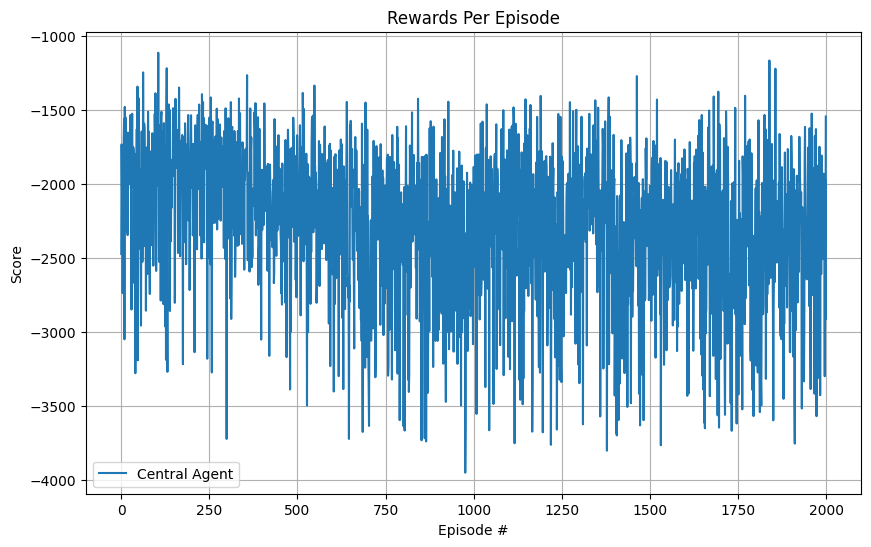

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(scores_central_agent, label='Central Agent')
plt.title("Rewards Per Episode")
plt.xlabel("Episode #")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

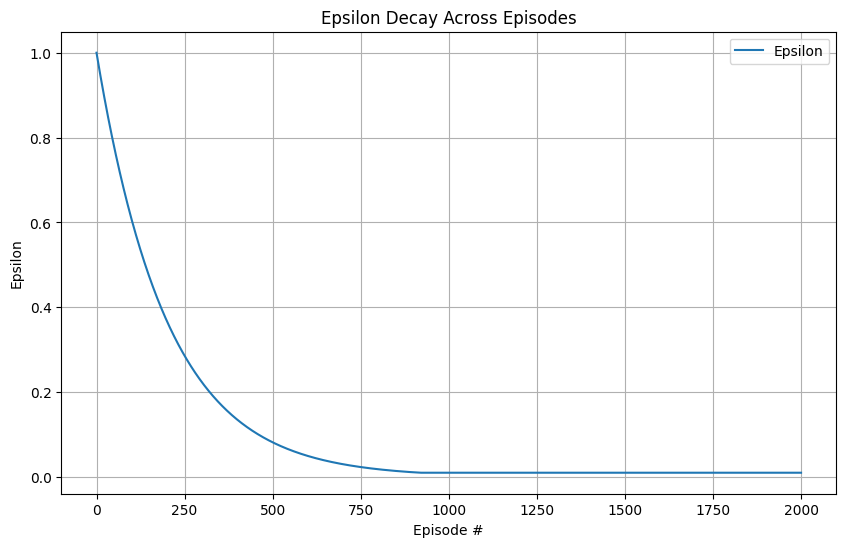

In [13]:
# Plot epsilon values for the final episode
plt.figure(figsize=(10, 6))
plt.plot(epsilons, label='Epsilon')
plt.title("Epsilon Decay Across Episodes")
plt.xlabel("Episode #")
plt.ylabel("Epsilon")
plt.legend()
plt.grid(True)
plt.show()

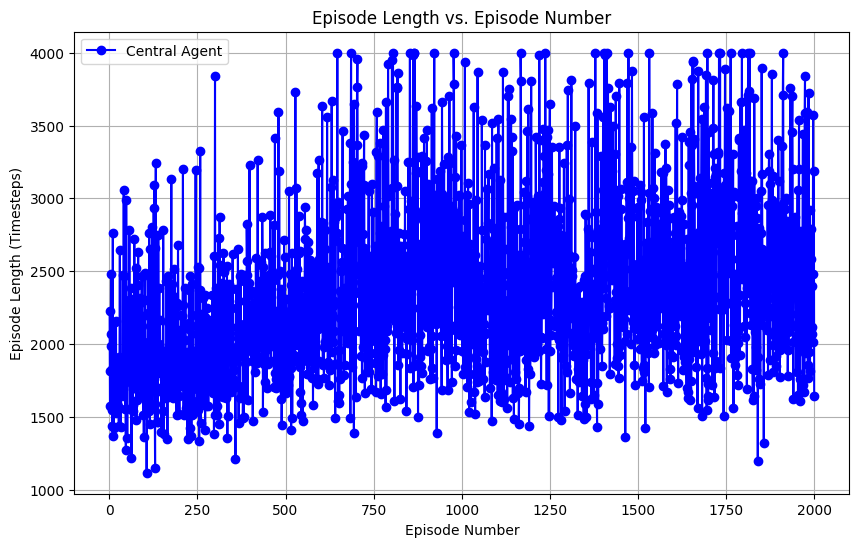

In [14]:
# Plot episode length
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot episode lengths for Agent1
plt.plot(range(1, len(episode_lengths_central_agent) + 1), episode_lengths_central_agent, marker='o', linestyle='-', color='blue', label='Central Agent')

plt.xlabel('Episode Number')
plt.ylabel('Episode Length (Timesteps)')
plt.title('Episode Length vs. Episode Number')

plt.legend()
plt.grid(True)
plt.show()

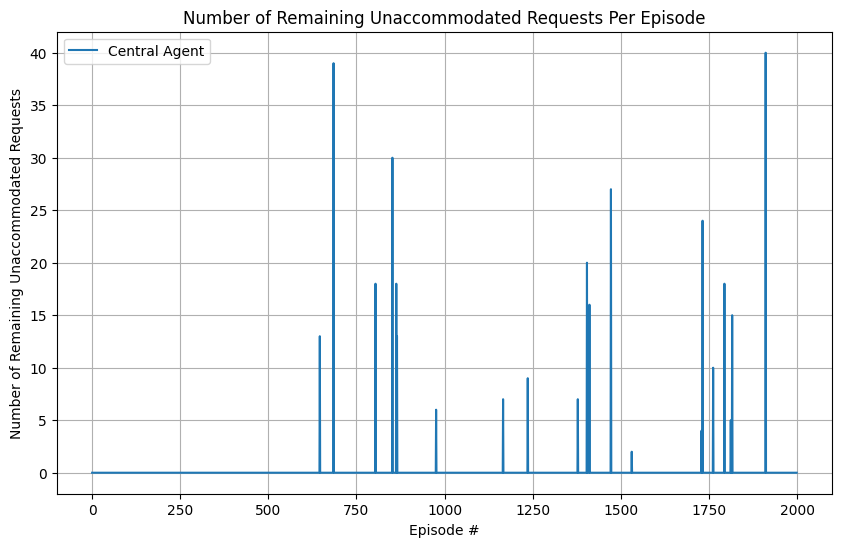

In [15]:
# Plot remaining unaccommodated requests per episode
plt.figure(figsize=(10, 6))
plt.plot(unaccom_reqs, label='Central Agent')
plt.title("Number of Remaining Unaccommodated Requests Per Episode")
plt.xlabel("Episode #")
plt.ylabel("Number of Remaining Unaccommodated Requests")
plt.legend()
plt.grid(True)
plt.show()

-------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------

# Testing Loop

In [16]:
import gym

env = TwoAirportSchedEnv(number_of_actions=num_actions, number_of_requests=1100, num_airports=2, cap_per_airport_arr= [6,6])

central_agent = Agent(state_size=26, action_size=num_actions, seed=0)

# Load the saved weights into the models
central_agent.qnetwork_local.load_state_dict(torch.load('checkpoint_central_agent.pth'))

def evaluate_agent(n_episodes=1):
    state = env.reset()
        
    for _ in range(n_episodes):
        counter = 0
        
        while True:
            # Using greedy policy (no exploration)
            central_action = central_agent.pred(state) 
            next_state, reward, done, _ = env.step(central_action)

            # print('Central action: ', central_action)
    
            if done or counter == 1500:
                env.evaluate_metrics()
                print("\n---------------------------------------------------------\n")
                # state = env.reset()
                break
                
            counter += 1
            
evaluate_agent()

Number of unaccomodated requests at the start of current episode: 573
Initial count of unit violation for airport1 is:  47
Initial count of unit violation for airport2 is:  47
Final count of unit violation for airport1 is:  47
Final count of unit violation for airport2 is:  48
Total schedule delay of airport1 is:  54925.0
Total schedule delay of airport2 is:  43232
Max shift of airport1:  281.0
Max shift of airport2:  156
Number of unaccommodated requests:  224

---------------------------------------------------------

